<a href="https://colab.research.google.com/github/EiffL/Tutorials/blob/master/PhotozCNN/cnn_photoz_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019-2020 Francois Lanusse.

Licensed under the Apache License, Version 2.0 (the "License");

# Estimating Photometric Redshifts with Keras

Author: [@EiffL](https://github.com/EiffL) (Francois Lanusse)

### Overview

In this tutorial, we learn how to combine Keras, TensorFlow Probability, and Google Colab to train a model photo-z inference in the cloud.

We will be using data from the HSC Survey, and more specifically from the Public Data Release 2, which can be found here: https://hsc-release.mtk.nao.ac.jp/doc/


The dataset contains postage stamps of galaxies in 5 HSC bands, along with corresponding spectroscopic redshifts.

Our goal will be to estimate redshift just by looking at a picture of a galaxy.

### Learning objectives

In this notebook, we will learn how to:
*   Build a tf.data.Dataset input pipeline.
*   Build a simple convolutional neural network with Keras.
*   Train a model on GPUs in the cloud.
*   (Stretch Goal) Use TensorFlow Probability to make a probabilistic model.

Note: this Tutorial was originaly presented at [Astro Hack Week 2019](https://github.com/AstroHackWeek/AstroHackWeek2019/tree/master/day4_bayesiandeep).

### Instructions for enabling GPU access

By default, notebooks are started without acceleration. To make sure that the runtime is configured for using GPUs, go to `Runtime > Change runtime type`, and select GPU in `Hardware Accelerator`.



### Installs and Imports

In [ ]:
import os
import re
import time
import json
import tensorflow as tf

### Checking for GPU access

In [ ]:
#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Downloading the data

In [ ]:
# Google Cloud Storage bucket for Estimator logs and storing
# the training dataset.
bucket = 'ahw2019' # Bucket setup for this AHW2019 tutorial
print('Using bucket: {}'.format(bucket))

Using bucket: ahw2019


In [ ]:
# Retrieve the catalogs
!gsutil -m cp gs://{bucket}/hsc_photoz/cat2/catalog_*.fits .
!gsutil -m cp gs://{bucket}/hsc_photoz/tfrecords2/* .

Copying gs://ahw2019/hsc_photoz/cat2/catalog_test.fits...
Copying gs://ahw2019/hsc_photoz/cat2/catalog_train.fits...
- [2/2 files][ 68.3 MiB/ 68.3 MiB] 100% Done                                    
Operation completed over 2 objects/68.3 MiB.                                     
Copying gs://ahw2019/hsc_photoz/tfrecords2/testing-00000-of-00001...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00004-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00000-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00007-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00005-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00006-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00001-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00003-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00002-of-00010...
Copying gs://ahw2019/hsc_photoz/tfrecords2/training-00008-of-00010...
Copying gs://ahw2019/

In [ ]:
from astropy.table import Table
cat_train = Table.read('catalog_train.fits')
cat_test = Table.read('catalog_test.fits')

## Building a tf.data.Dataset Input Pipeline

The first step is to read the data from the tfrecords format on disk into a tf.data.Dataset. This TensorFlow API is the canonical way to supply data to a model during training. It is fast and optimized, and supports distributed training!


In [ ]:
# The data is saved as a TFRecord, needs to get parsed and turned into a dataset
dset = tf.data.TFRecordDataset(['training-%05d-of-00010'%i for i in range(10)])

In [ ]:
# To extract one example from the TFRecord, we can use the following syntax:
for i in dset.take(1):
  print(i)

tf.Tensor(b'\n\xcd\xa1\x05\n$\n\x18attrs/specz_redshift_err\x12\x08\x12\x06\n\x04\x17\xb7\xd18\n)\n\x1dattrs/i_sdssshape_psf_shape22\x12\x08\x12\x06\n\x04\xa1\xec\x8a=\n%\n\x19attrs/y_sdssshape_shape11\x12\x08\x12\x06\n\x04I\xb3\xe8>\n%\n\x19attrs/y_sdssshape_shape12\x12\x08\x12\x06\n\x047-\x83\xbc\n(\n\x1cattrs/i_cmodel_dev_fluxsigma\x12\x08\x12\x06\n\x04\xe1\xc7\x01C\n#\n\x17attrs/g_cmodel_dev_flux\x12\x08\x12\x06\n\x04\xce\x945F\n\'\n\x1battrs/z_cmodel_exp_magsigma\x12\x08\x12\x06\n\x04\xae]\xbb:\n%\n\x19attrs/y_sdssshape_shape22\x12\x08\x12\x06\n\x04=:\xa8>\n\'\n\x1battrs/z_cmodel_dev_magsigma\x12\x08\x12\x06\n\x04lj\xba:\n)\n\x1dattrs/r_sdssshape_psf_shape11\x12\x08\x12\x06\n\x04\xa0>\xca=\n)\n\x1dattrs/r_sdssshape_psf_shape12\x12\x08\x12\x06\n\x04\x8e\xa8\x94\xbb\n)\n\x1dattrs/r_sdssshape_psf_shape22\x12\x08\x12\x06\n\x04\x10\x8b\xb9=\n\x1e\n\x12attrs/r_cmodel_mag\x12\x08\x12\x06\n\x04\xec\xec\x9cA\n%\n\x19attrs/r_sdssshape_shape11\x12\x08\x12\x06\n\x04A9\xc7>\n%\n\x19attrs/r_sds

The data is currently stored in a serialized format, as strings. We need to decode it.

In [ ]:
img_len = 64
num_bands = 5

# This function defines the operations to apply to a serialized example to
# turn it back into a dictionary object
def parse_example(example):

  # First, let's define what fields we are expecting
  data_fields = {
      "image/encoded": tf.io.FixedLenFeature((), tf.string),
      "image/format": tf.io.FixedLenFeature((), tf.string),
      "id": tf.io.FixedLenFeature((), tf.int64)
  }
  for k in cat_train.colnames[5:]:
    data_fields['attrs/'+k] = tf.io.FixedLenFeature([], tf.float32)

  parsed_example = tf.io.parse_single_example(example, data_fields)

  # Decode the image from string format
  cutout = tf.io.decode_raw(parsed_example['image/encoded'], out_type=tf.float32) 
  cutout = tf.reshape(cutout, [img_len, img_len, num_bands])

  # Outputs results as a dictionary
  output_dict = {"cutout": cutout}
  for k in cat_train.colnames[5:]:
    output_dict[k] = parsed_example['attrs/'+k]

  return output_dict

With this decoding function defined, we can apply it to the dataset by using the dataset.map() method:

In [ ]:
train_dset = dset.map(parse_example)

Let's have a look at the content of this new dataset:

In [ ]:
for i in train_dset.take(1):
  print(i)

{'cutout': <tf.Tensor: shape=(64, 64, 5), dtype=float32, numpy=
array([[[ 1.42860785e-02, -3.73271368e-02, -8.00432712e-02,
          1.68011785e-01, -1.14968955e-03],
        [ 3.54450978e-02, -7.84243457e-03,  7.13276640e-02,
         -1.42931923e-01, -2.98915625e-01],
        [ 5.76633587e-03,  2.51381043e-02, -2.27141455e-02,
         -6.58935830e-02,  4.00278330e-01],
        ...,
        [-9.51873418e-03,  5.43134063e-02, -3.14920060e-02,
         -2.05706120e-01,  9.59639996e-02],
        [ 1.89720672e-02,  2.53469851e-02,  1.69368848e-01,
          1.59295872e-01, -4.36530739e-01],
        [-1.61630847e-02,  7.68938512e-02,  5.04950248e-02,
          1.12778299e-01, -7.13033602e-02]],

       [[-3.06963772e-02,  6.61610020e-03,  5.50234057e-02,
         -1.87741667e-02,  2.46280819e-01],
        [ 6.05988652e-02, -4.44212966e-02, -7.38758668e-02,
         -2.94351697e-01, -2.96003938e-01],
        [ 2.63932832e-02,  9.19254497e-02, -1.69459321e-02,
          1.45460129e-01,  2.

Now our dataset is decoded into numbers and arrays.

### Dataset preprocessing

An important step of any input pipeline is to make
sure the data is reasonably well behaved before 
feeding to the neural network. Here are some common strategies:


*   Apply log() to values with large dynamic range
*   Remove means, and standardize standard deviation
*   etc...


So, we begin by looking at our data


In [ ]:
# What's in our dataset:
train_dset

<MapDataset shapes: {cutout: (64, 64, 5), a_g: (), a_r: (), a_i: (), a_z: (), a_y: (), g_extendedness_value: (), r_extendedness_value: (), i_extendedness_value: (), z_extendedness_value: (), y_extendedness_value: (), g_localbackground_flux: (), r_localbackground_flux: (), i_localbackground_flux: (), z_localbackground_flux: (), y_localbackground_flux: (), g_cmodel_flux: (), g_cmodel_fluxsigma: (), g_cmodel_exp_flux: (), g_cmodel_exp_fluxsigma: (), g_cmodel_dev_flux: (), g_cmodel_dev_fluxsigma: (), r_cmodel_flux: (), r_cmodel_fluxsigma: (), r_cmodel_exp_flux: (), r_cmodel_exp_fluxsigma: (), r_cmodel_dev_flux: (), r_cmodel_dev_fluxsigma: (), i_cmodel_flux: (), i_cmodel_fluxsigma: (), i_cmodel_exp_flux: (), i_cmodel_exp_fluxsigma: (), i_cmodel_dev_flux: (), i_cmodel_dev_fluxsigma: (), z_cmodel_flux: (), z_cmodel_fluxsigma: (), z_cmodel_exp_flux: (), z_cmodel_exp_fluxsigma: (), z_cmodel_dev_flux: (), z_cmodel_dev_fluxsigma: (), y_cmodel_flux: (), y_cmodel_fluxsigma: (), y_cmodel_exp_flux: (

Ok, we see that this dataset is a dictionary, field `inputs` are hsc cutouts in 5 bands (g,r,i,z,y), this will be the inputs to our CNN. We also see a `specz_redshift` entry, that will be our prediction target. Let's have a look at these.

Populating the interactive namespace from numpy and matplotlib


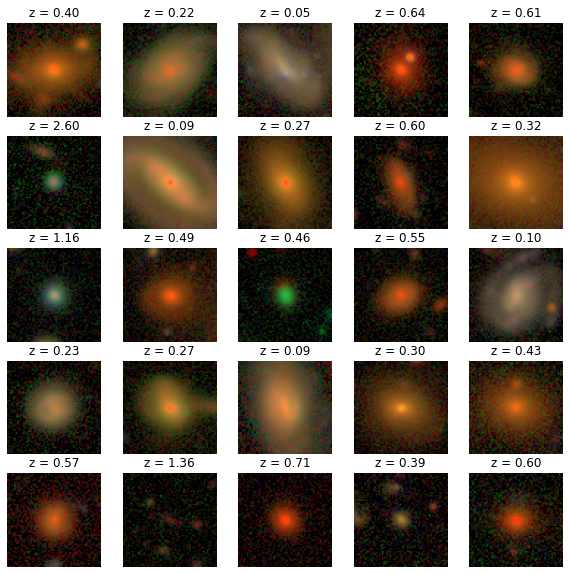

In [ ]:
from astropy.visualization import make_lupton_rgb
%pylab inline 

# The data is in 5 bands GRIZY, but for visualisation we use only the
# 3 first bands and luptonize them
def luptonize(img):
  return make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0],
                         Q=15, stretch=0.5, minimum=0)

plt.figure(figsize=(10,10))
for i, entry in enumerate(train_dset.take(25)):
  plt.subplot(5,5,i+1)
  plt.imshow(luptonize(entry['cutout']))
  plt.title('z = %0.02f'%entry['specz_redshift'])
  plt.axis('off')

How nice is that :-) We can extract postage stamps and the corresponding spectroscopic redshift for these objects. 

Before doing anything else, we should take a closer look at the  data and check that it's well behaved.

In [ ]:
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(train_dset.take(1000)):
  specz.append(entry['specz_redshift'])
  cutouts.append(entry['cutout'])

cutouts = np.stack(cutouts)
specz = np.stack(specz)

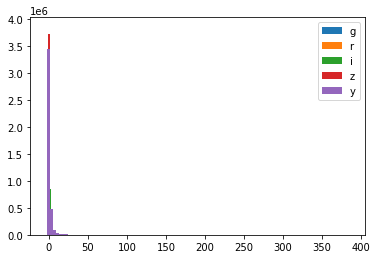

In [ ]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b);
plt.legend()

# Problem ?

Do you see a problem in this histogram?

Let's have a look at a few images:

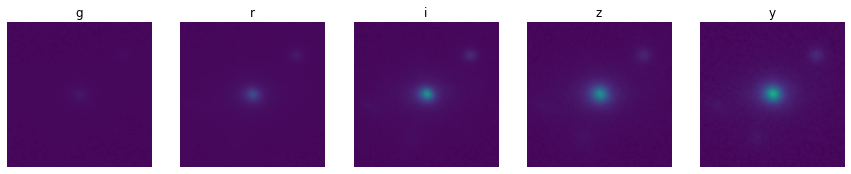

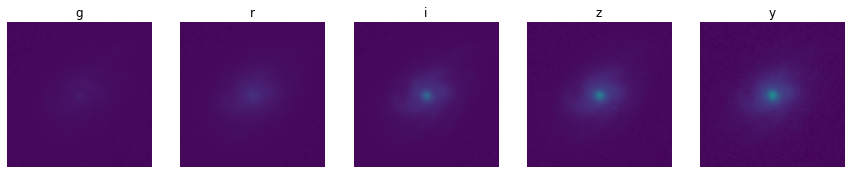

In [ ]:
plt.figure(figsize=(15,3))
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[0,:,:,i],vmin=-1,vmax=50)
  plt.title(b)
  plt.axis('off')

plt.figure(figsize=(15,3))
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[1,:,:,i],vmin=-1,vmax=50)
  plt.title(b)
  plt.axis('off')

In the plot above, each row is a different galaxy, and each column is a different band.

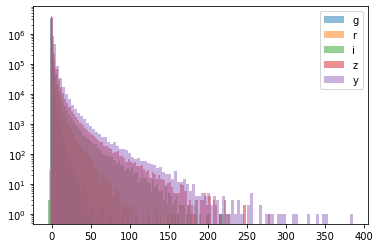

In [ ]:
# Let's look at it in log scale
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5);
plt.legend()
plt.yscale('log')

This is terrible, the tail of this distribution in pixel intensity is going to kill our neural networks. We need to standardize the data.

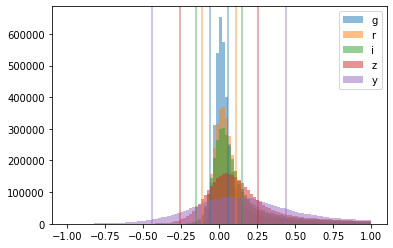

In [ ]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5,range=[-1,1]);
  sigma = mad_std(cutouts[...,i].flatten())
  scaling.append(sigma)
  plt.axvline(sigma, color='C%d'%i,alpha=0.5)
  plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()

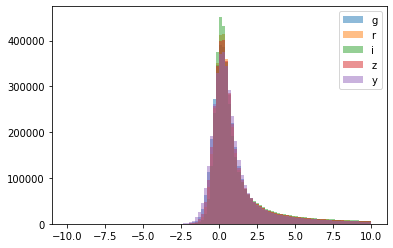

In [ ]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
legend()

Sweet! Now there is still an unsigthly tail towards very large values. We are going to apply range compression to get rid of it.

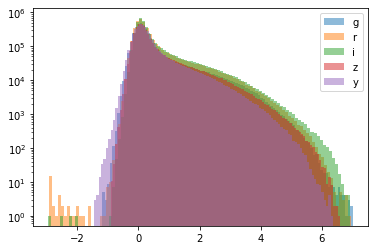

In [ ]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(np.arcsinh(cutouts[...,i].flatten()/scaling[i]/3),100,
           label=b, alpha=0.5);
plt.legend()
plt.yscale('log')

![Perfection](https://i.kym-cdn.com/entries/icons/original/000/022/900/704.jpg)

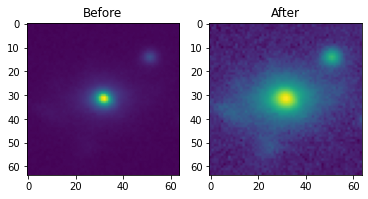

In [ ]:
# we can have a look at individual postage stamps with or without this scaling
subplot(121)
imshow(cutouts[0,:,:,1]/scaling[1])
title('Before')
subplot(122)
imshow(np.arcsinh(cutouts[0,:,:,1]/scaling[1]/3))
title('After');

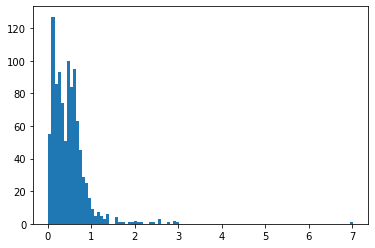

In [ ]:
# Let's just check the specz values
plt.hist(specz,100);
# Should be ok

Now that we have defined a scaling for the data that should be appropriate, we can build a scaling function and apply it to the dataset:

In [ ]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
  def range_compression(img):
    return tf.math.asinh(img / tf.constant(scaling) / 3. )
  # Our preprocessing function only returns the postage stamps, and the specz
  return range_compression(example['cutout']), example['specz_redshift']

In [ ]:
dset = train_dset.map(preprocessing)

In [ ]:
# Let's draw some examples from this now
cutouts=[]
specz = []
for (batch, entry) in enumerate(dset.take(1000)):
  specz.append(entry[1])
  cutouts.append(entry[0])

cutouts = np.stack(cutouts)
specz = np.stack(specz)

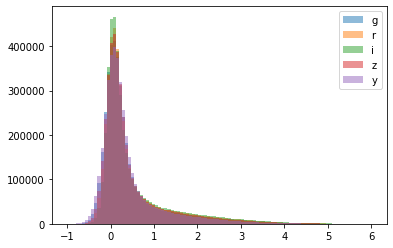

In [ ]:
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.hist(cutouts[...,i].flatten(),100, label=b,alpha=0.5, range=[-1,6]);
plt.legend()

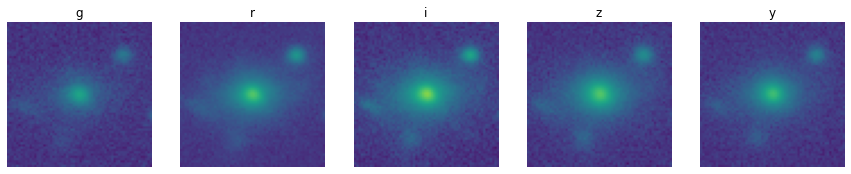

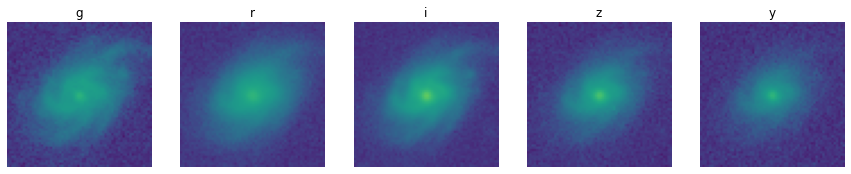

In [ ]:
plt.figure(figsize=(15,3))
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[0,:,:,i],vmin=-1,vmax=6)
  plt.title(b)
  plt.axis('off')

plt.figure(figsize=(15,3))
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[1,:,:,i],vmin=-1,vmax=6)
  plt.title(b)
  plt.axis('off')

Sweeeeeet

### Create the input pipeline

Now that we know how to preprocess the data, we can build the input pipeline. Below is a function that creates a Dataset object from the tfrecords files, decode them, applies preprocessing, shuffles the dataset, and create batches of data. Finally the function returns the dataset, that Keras models can directly ingest.

More information about tf.data.dataset API can be found here: 

https://www.tensorflow.org/guide/datasets


In [ ]:
# Using a mapping function to apply preprocessing to our data
def preprocessing(example):
  img = tf.math.asinh(example['cutout'] / tf.constant(scaling) / 3. )
  return img, example['specz_redshift']

def input_fn(mode, batch_size):
  """
  mode: tf.estimator.ModeKeys.TRAIN or tf.estimator.ModeKeys.EVAL
  """
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = tf.data.Dataset.list_files('training-*')
    dataset = dataset.interleave(tf.data.TFRecordDataset, 
                                 cycle_length=10,
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat()
  else:
    dataset = tf.data.TFRecordDataset('testing-00000-of-00001')
    
  dataset = dataset.map(parse_example)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(10000)
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.map(preprocessing) # Apply data preprocessing
  dataset = dataset.prefetch(-1) # fetch next batches while training current one (-1 for autotune)
  return dataset

## Building a simple regression model with Keras

In [ ]:
import tensorflow.keras as tfk

def create_model():
  model = tfk.models.Sequential()
  model.add(tfk.layers.Conv2D(32, kernel_size=5, padding='same',
                                   input_shape=(64,64,5), activation='elu', strides=2))
  model.add(tfk.layers.BatchNormalization())
  
  model.add(tfk.layers.Conv2D(64, kernel_size=3, padding='same', 
                              activation='elu'))
  model.add(tfk.layers.BatchNormalization())
  
  model.add(tfk.layers.Conv2D(128, kernel_size=3, padding='same', strides=2, 
                                   activation='elu'))
  model.add(tfk.layers.BatchNormalization())  

  model.add(tfk.layers.Conv2D(256, kernel_size=3, padding='same', 
                                   activation='elu', strides=2))
  model.add(tfk.layers.BatchNormalization())

  model.add(tfk.layers.Conv2D(512, kernel_size=3, padding='same', 
                                   activation='elu', strides=2))
  model.add(tfk.layers.BatchNormalization())
  
  model.add(tfk.layers.Flatten())
  model.add(tfk.layers.Dense(512))
  model.add(tfk.layers.Activation('relu'))
  model.add(tfk.layers.Dense(256))
  model.add(tfk.layers.Activation('relu'))
  model.add(tfk.layers.Dense(1))
  
  model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                loss=tfk.metrics.mse)
  return model

In [ ]:
model = create_model()

# print model layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        4032      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         2

In [ ]:
# We define the batch size
BATCH_SIZE = 64

# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9

lr_decay = tfk.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

In [ ]:
# We actually create our training dataset with our input function
dataset_training = input_fn(tf.estimator.ModeKeys.TRAIN, BATCH_SIZE)

In [ ]:
# We are ready to train our model
model.fit(dataset_training,
          steps_per_epoch=20000//BATCH_SIZE, 
          epochs=15,
          callbacks=[lr_decay])

In [ ]:
# Now that the model is 'trained', we can apply it
dataset_eval = input_fn(tf.estimator.ModeKeys.EVAL, BATCH_SIZE)
preds = model.predict(dataset_eval)

In [ ]:
%pylab inline
hist2d(cat_test['specz_redshift'][:20000], preds.squeeze()[:20000], 64,
       range=[[0,1],[0,1]], cmap='gist_stern'); 
gca().set_aspect('equal');
plot([0,1],[0,1],color='r')
xlabel('Spectroscopic Redshift')
ylabel('Predicted Redshift')

Yes! It's learning something! But the results may not be perfect yet. Here  is a list of things to do to improve the model:
*   Train for longer ^^' Deep Learning requires a lot of patience
*   Include additional information, like the extinction in each band, which is included in the dataset. 
    *   You would need to change the input_fn so that the returned dataset contains additional fields
    *   See how to use multiple inputs in a Keras model here: https://keras.io/getting-started/functional-api-guide/
*   Use a better CNN model. A simple CNN like this one is typically very suboptimal. Much better results would be achieved with a ResNet model for instance, see here for a Keras example: https://keras.io/examples/cifar10_resnet/
*   Move away from an MSE loss and embrace TensorflowProbability \o/ Replacing the output of the model by a Mixture Density would be a much better idea. https://www.tensorflow.org/probability/api_docs/python/tfp/layers/MixtureNormal

